<a href="https://colab.research.google.com/github/kristenvonbecker/spotify_data_analysis/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Spotify Data Analysis, Part 2: The Analysis**

---


by Kristen Beck ([kristenvonbecker.com](https://kristenvonbecker.com))

This notebook constitutes the second phase of the Spotify Data Analysis project: the analysis. The code which follows, you will:
1. Upload a CSV file containing audio feature data for music tracks appearing on several Spotify playlists (either one generated data.ipyn or contained in the [project directory](https://drive.google.com/drive/folders/1kQTATtKRw0ngyYxD3dK1yiOyh3NgbNSM?usp=sharing)).
2. Read the data into a Pandas dataframe and perform processing to streamline visualization tasks (e.g. map categorical variables to descriptive values, define lookup tables, and define function for playlist classification).
3. Use the [Matplotlib](https://matplotlib.org/) and [Seaborn](https://seaborn.pydata.org/) libraries to generate graphics illustrating the distributions and relationships between each of the data's categorical and quantitative audio features.

## Getting started





### Import dependencies

In [ ]:
# for importing/exporting files to/from Colab
from google.colab import files
import io

# for handling data
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
import numpy as np
from datetime import datetime
import random
import pprint

# for visualizations
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import seaborn as sns

### Import the data

Upload the CSV file containing the track data -- either the one you created in Part 1, or the one found in the project directory.

In [ ]:
# choose the CSV file you wish to upload for analysis
uploaded = files.upload()

Saving track_df.csv to track_df.csv


Read the CSV file into a Pandas dataframe indexed by the track ID.

Ensure that features which have list-type values -- `artists`, `images`, and `image_sizes` -- have the correct datatype.

In [ ]:
# adjust the filename, if needed
track_df = pd.read_csv(io.BytesIO(uploaded['track_df.csv']), index_col='id')

track_df['artists'] = track_df['artists'].apply(eval)
track_df['images'] = track_df['images'].apply(eval)
track_df['image_sizes'] = track_df['image_sizes'].apply(eval)

track_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2528 entries, 3BHFResGQiUvbYToUdaDQz to 4xQ81l1RAd6ENI35BOyHSe
Data columns (total 57 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   name                                   2528 non-null   object 
 1   artists                                2528 non-null   object 
 2   album                                  2528 non-null   object 
 3   images                                 2528 non-null   object 
 4   image_sizes                            2528 non-null   object 
 5   release_dt                             2528 non-null   object 
 6   duration                               2528 non-null   float64
 7   popularity                             2528 non-null   int64  
 8   explicit                               2528 non-null   bool   
 9   dance                                  2528 non-null   float64
 10  energy                                

## Preparing for analysis

Classify features by the type of track-related data they provide, and identify the playlists which can be used for grouping and/or comparison.

In [ ]:
meta = [
    'name',
    'artists',
    'album',
    'images',
    'image_sizes',
]

quant_features = [
    'tempo',
    'dance',
    'energy',
    'loud',
    'speech',
    'acoustic',
    'instrument',
    'live',
    'valence',
    'duration',
    'popularity',
    'release_dt',
]

conf_features = [
    'tempo_conf',
    'key_conf',
    'mode_conf',
    'time_sig_conf'
]

cat_features = [
    'explicit',
    'key',
    'mode',
    'time_sig'
]

all_features = meta + quant_features + conf_features + cat_features

all_playlists = [x for x in track_df.columns if x not in all_features]

print(f"The dataframe contains track data for the following playlists:\n")
for playlist in all_playlists:
  print(playlist)

The dataframe contains track data for the following playlists:

All Out 2000s
All Out 50s
All Out 60s
All Out 70s
All Out 80s
All Out 90s
Are & Be
Classical Garden
Fresh Finds Country
Fresh Finds Dance
Fresh Finds Experimental
Fresh Finds Hip-Hop
Fresh Finds Indie
Fresh Finds Latin
Fresh Finds Pop
Fresh Finds Presents... Class of 2019
Fresh Finds R&B
Fresh Finds Rock
Hot Country
Melantronic
Music for Plants
New Music Friday
Peaceful Piano
RapCaviar
Rock Classics
Rock This
Signed XOXO
Soft Pop Hits
Today's Top Hits 
Viva Latino
just hits
mint


Define common and custom playlist groupings.

In [ ]:
genre = [
    "RapCaviar",
    "Hot Country",
    "Viva Latino",
    "Peaceful Piano",
    "Are & Be",
    "mint",
    "Rock This",
    "Soft Pop Hits",
    "Signed XOXO"
    ]

decade = [
    "All Out 2000s",
    "All Out 90s",
    "All Out 80s",
    "All Out 70s",
    "All Out 60s",
    "All Out 50s"
    ]

# adjust this if using a dataset YOU generated (rather than the one provided)
my_playlists = [
    "Melantronic",
    "Music for Plants",
    "Classical Garden"
]

Map values of categorical features to more meaningful ones (for labeling plots).

In [ ]:
track_df[['name', 'key','mode','time_sig']].head()

,name,key,mode,time_sig
id,,,,
3BHFResGQiUvbYToUdaDQz,Enough Is Enough,0,1,4
5L3ecxQnQ9qTBmnLQiwf0C,K-POP,5,0,4
741UUVE2kuITl0c6zuqqbO,Barbie World (with Aqua) [From Barbie The Album],0,1,4
1vYXt7VSjH9JIM5oRRo7vA,Dance The Night (From Barbie The Album),11,0,4
3k79jB4aGmMDUQzEwa46Rz,vampire,5,1,4


In [ ]:
key_mapping = {
  "0": "C",
  "1": "C♯",
  "2": "D",
  "3": "D♯",
  "4": "E",
  "5": "F",
  "6": "F♯",
  "7": "G",
  "8": "G♯",
  "9": "A",
  "10": "A♯",
  "11": "B",
}

mode_mapping = {
    "0": "minor",
    "1": "major"
}

def time_sig_mapping(num):
  return f"{num}/4"

track_df['explicit'] = pd.Categorical(track_df['explicit'], ordered=True, categories=[False, True])

keys = track_df['key'].astype('str').map(key_mapping)
track_df['key'] = pd.Categorical(keys, ordered=True, categories=key_mapping.values())

modes = track_df['mode'].astype('str').map(mode_mapping)
track_df['mode'] = pd.Categorical(modes, ordered=True, categories=mode_mapping.values())

time_sigs = track_df['time_sig'].astype('str').map(time_sig_mapping)
ordered_time_sigs = np.sort(time_sigs.unique())
track_df['time_sig'] = pd.Categorical(time_sigs, ordered=True, categories=ordered_time_sigs)

categories = {
    "explicit": [False, True],
    "key": key_mapping.values(),
    "mode": mode_mapping.values(),
    "time_sig": ordered_time_sigs,
    "playlist": None
}

In [ ]:
track_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2528 entries, 3BHFResGQiUvbYToUdaDQz to 4xQ81l1RAd6ENI35BOyHSe
Data columns (total 57 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   name                                   2528 non-null   object  
 1   artists                                2528 non-null   object  
 2   album                                  2528 non-null   object  
 3   images                                 2528 non-null   object  
 4   image_sizes                            2528 non-null   object  
 5   release_dt                             2528 non-null   object  
 6   duration                               2528 non-null   float64 
 7   popularity                             2528 non-null   int64   
 8   explicit                               2528 non-null   category
 9   dance                                  2528 non-null   float64 
 10  energy                    

In [ ]:
track_df[['name', 'key','mode','time_sig']].head()

,name,key,mode,time_sig
id,,,,
3BHFResGQiUvbYToUdaDQz,Enough Is Enough,C,major,4/4
5L3ecxQnQ9qTBmnLQiwf0C,K-POP,F,minor,4/4
741UUVE2kuITl0c6zuqqbO,Barbie World (with Aqua) [From Barbie The Album],C,major,4/4
1vYXt7VSjH9JIM5oRRo7vA,Dance The Night (From Barbie The Album),B,minor,4/4
3k79jB4aGmMDUQzEwa46Rz,vampire,F,major,4/4


Define feature characteristics (for use in plot titles).

In [ ]:
from typing_extensions import TypeVarTuple
feature_specs = {
    'tempo': {
        'label': 'Tempo',
        'range': None,
        'unit': 'bpm'
        },
    'dance': {
        'label': 'Danceability',
        'range': [0, 1],
        'unit': None
        },
    'energy': {
        'label': 'Energy',
        'range': [0, 1],
        'unit': None
        },
    'loud': {
        'label': 'Loudness',
        'range': None,
        'unit': 'dB'
        },
    'speech': {
        'label': 'Speechiness',
        'range': [0, 1],
        'unit': None
        },
    'acoustic': {
        'label': 'Acousticness',
        'range': [0, 1],
        'unit': None
        },
    'instrument': {
        'label': 'Instrumentalness',
        'range': [0, 1],
        'unit': None
        },
    'live': {
        'label': 'Liveness',
        'range': [0, 1],
        'unit': None
        },
    'valence': {
        'label': 'Valence',
        'range': [0, 1],
        'unit': None
        },
    'duration': {
        'label': 'Duration',
        'range': None,
        'unit': 'sec'
        },
    'popularity': {
        'label': 'Popularity',
        'range': [1, 100],
        'unit': None
        },
    'release_dt': {
        'label': 'Release Date',
        'range': None,
        'unit': None
        },
    'explicit': {
        'label': 'Explicit',
        'values': [False, True],
        'unit': None
        },
    'key': {
        'label': 'Key',
        'values': key_mapping.values(),
        'unit': None
        },
    'mode': {
        'label': 'Modality',
        'values': mode_mapping.values(),
        'unit': None
        },
    'time_sig': {
        'label': 'Time Signature',
        'values': ordered_time_sigs,
        'unit': None
        },
    'playlist': {
        'label': 'Playlist',
        'values': None,
        'unit': None
    }
}

Define a new categorical feature for the dataframe, called `playlist`, which identifies which playlist (from a given collection) a track belongs to. Tracks belonging to none of the indicated playlists, or to more than one of them, will have missing values for `playlist`.

In [ ]:
def get_playlists(df, playlist_names):
  in_num_playlists = df[playlist_names].sum(axis=1)
  in_unique_playlist = in_num_playlists == 1

  df['playlist'] = None
  df['playlist'].mask(in_unique_playlist, other=df[playlist_names].idxmax(axis="columns"), inplace=True)

  return df['playlist']

Take a peek at some of the data fields we'll be using most in the analysis below for a random sample of the data:

In [ ]:
track_df['playlist'] = get_playlists(track_df, all_playlists)
track_df[['name', 'playlist'] + quant_features + cat_features].sample(frac=1).head()

,name,playlist,tempo,dance,energy,loud,speech,acoustic,instrument,live,valence,duration,popularity,release_dt,explicit,key,mode,time_sig
id,,,,,,,,,,,,,,,,,,
1mea3bSkSGXuIRvnydlB5b,Viva La Vida,All Out 2000s,138.015,0.486,0.617,-7.115,0.029,0.095,0.000,0.109,0.417,242.373,90,2008-05-26,False,F,minor,4/4
4f0i8ligJspqXf8qeAV1sS,Make My Day (with David Guetta),Signed XOXO,110.043,0.799,0.688,-7.153,0.251,0.059,0.000,0.097,0.567,135.253,70,2023-06-23,True,F,minor,4/4
4FlYcJnfkeBpowEHJ72Bmt,Rockin' Robin,All Out 50s,171.992,0.541,0.608,-13.083,0.106,0.298,0.000,0.234,0.938,160.080,64,1958-01-01,False,G,major,4/4
3l6RgZRKf4FfSc2FJlesEL,Pull Me Through,Rock This,132.398,0.452,0.934,-5.034,0.093,0.128,0.309,0.095,0.299,188.708,64,2023-07-13,False,F,minor,4/4
1Dr1fXbc2IxaK1Mu8P8Khz,When I Come Around,All Out 90s,97.546,0.531,0.909,-4.236,0.034,0.018,0.000,0.231,0.814,178.000,80,1994-02-01,False,B,major,4/4


## Analysis

Set graphics preferences.

In [ ]:
sns.set_style("ticks")
palette = sns.color_palette("colorblind")

def force_aspect(ax,aspect=1):
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    ax.set_aspect(abs(x1 - x0) / abs(y1 - y0) / aspect)

### Categorical features

Our data contains 4 categorical features: `explicit` (a boolean value), and `key`, `mode`, and `time_sig` (all strings).

Investigate the distribution of key by mode for all tracks.

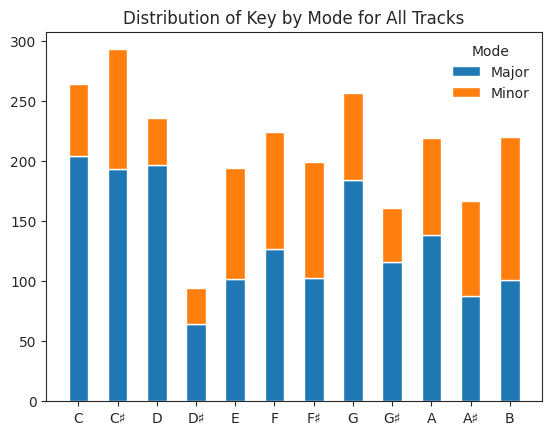

In [ ]:
key_mode = track_df.groupby('mode')['key'].value_counts(sort=False)

key_counts = {
    "Major": key_mode[("major",)],
    "Minor": key_mode[("minor",)]
}

fig, ax = plt.subplots()

ax.set_title("Distribution of Key by Mode for All Tracks")

width = 0.5
bottom = np.zeros(12)

for mode, count in key_counts.items():
  plot = ax.bar(key_mapping.values(), count, width, label=mode, bottom=bottom)
  bottom += count

ax.legend(loc="upper right", title="Mode", frameon=False)

plt.show()

Investigate the distribution of time signature for all tracks.

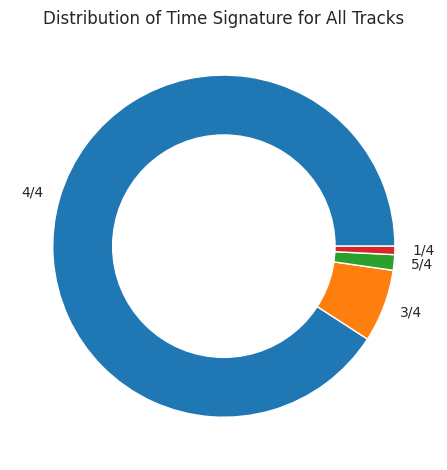

In [ ]:
counts = track_df['time_sig'].value_counts()

fig, ax = plt.subplots()

plt.title("Distribution of Time Signature for All Tracks")

plt.pie(counts, labels=counts.index)

hole = plt.Circle((0, 0), 0.65, facecolor='white')
plt.gcf().gca().add_artist(hole)

plt.tight_layout()
plt.show()

Investigate the frequency of explicit lyrics within different playlist groupings.

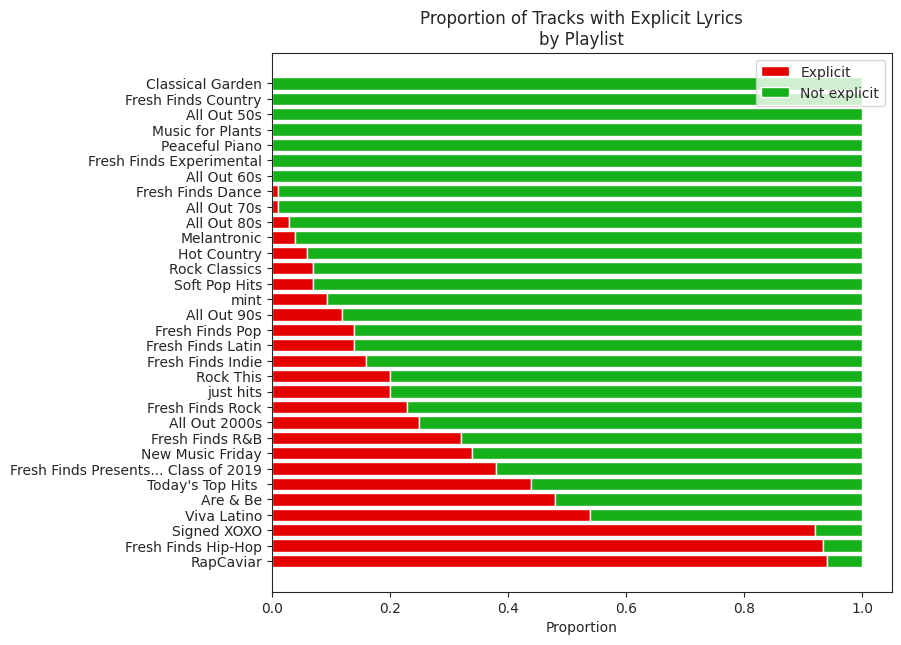

In [ ]:
explicit = []
not_explicit = []

for playlist in all_playlists:

  playlist_mask = track_df[playlist] == 1
  count = track_df[playlist_mask]['explicit'].value_counts()

  try:
    explicit.append(count[True])
  except KeyError:
    explicit.append(0)

  try:
    not_explicit.append(count[False])
  except KeyError:
    not_explicit.append(0)

data = {
    "playlist": all_playlists,
    "explicit": explicit,
    "not_explicit": not_explicit
    }

df = pd.DataFrame(data=data)

df['explicit_p'] = df['explicit'] / (df['not_explicit'] + df['explicit'])
df['not_explicit_p'] = df['not_explicit'] / (df['not_explicit'] + df['explicit'])

df = df.sort_values('explicit_p', ascending=False)

fig, ax = plt.subplots(figsize=(8,7))

ax.set_title('Proportion of Tracks with Explicit Lyrics\nby Playlist')

y_pos = np.arange(len(all_playlists))
bar1 = ax.barh(y_pos, df["explicit_p"], color='xkcd:red', align='center')
bar2 = ax.barh(y_pos, df["not_explicit_p"], left=df["explicit_p"], color='xkcd:green', align='center')

ax.set_yticks(y_pos, labels=df["playlist"])
ax.set_xlabel('Proportion')

plt.legend(handles=[bar1, bar2], labels=["Explicit", "Not explicit"], loc="best")

plt.show()

### Quantitative features

There are 11 quantitative features: `tempo`, `dance`, `energy`, `loud`, `speech`, `acoustic`, `instrument`, `live`, `valence`, `duration`, and `popularity`.

A correlation heatmap illustrates the strength of the linear relationship between two quantitative features. Correlation coefficients of larger magnitude (corresponding to darker colors at the ends of the spectrum) indicate a stronger linear relationship between two features.

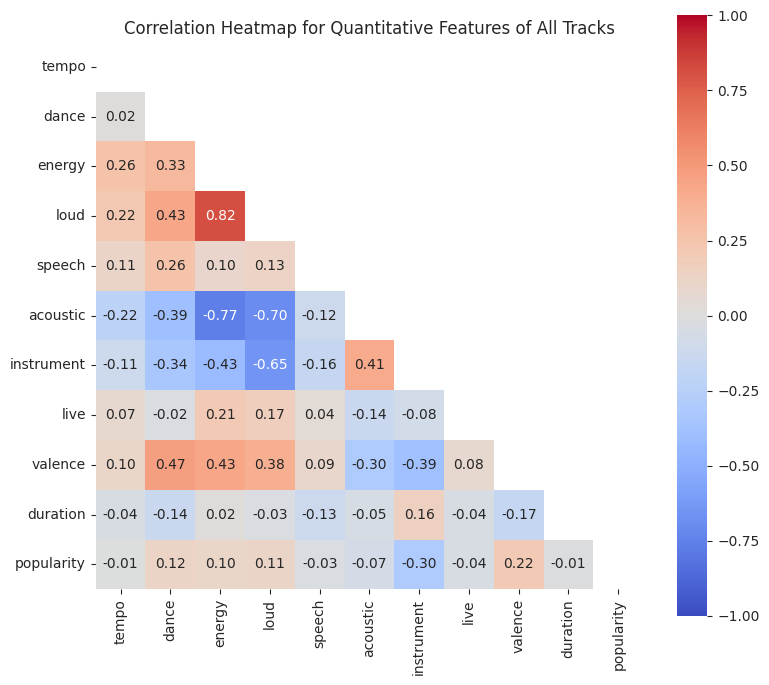

In [ ]:
fig, ax = plt.subplots(figsize=(8,7))

plt.title("Correlation Heatmap for Quantitative Features of All Tracks")

mask = np.triu(np.ones_like(track_df[quant_features].corr(numeric_only=True)))
heatmap = sns.heatmap(track_df[quant_features].corr(numeric_only=True), mask=mask, robust=True, vmin=-1, vmax=1, annot=True, fmt="1.2f", cmap="coolwarm")

force_aspect(ax)

plt.tight_layout()
plt.show()

Pairplot of select numerical features for select playlists:

In [ ]:
features = ['energy', 'loud', 'acoustic', 'valence', 'speech']

my_playlists = [
    "RapCaviar",
    "Viva Latino",
    "Are & Be",
    "Rock This",
    "Classical Garden",
]

track_df['playlist'] = get_playlists(track_df, my_playlists)

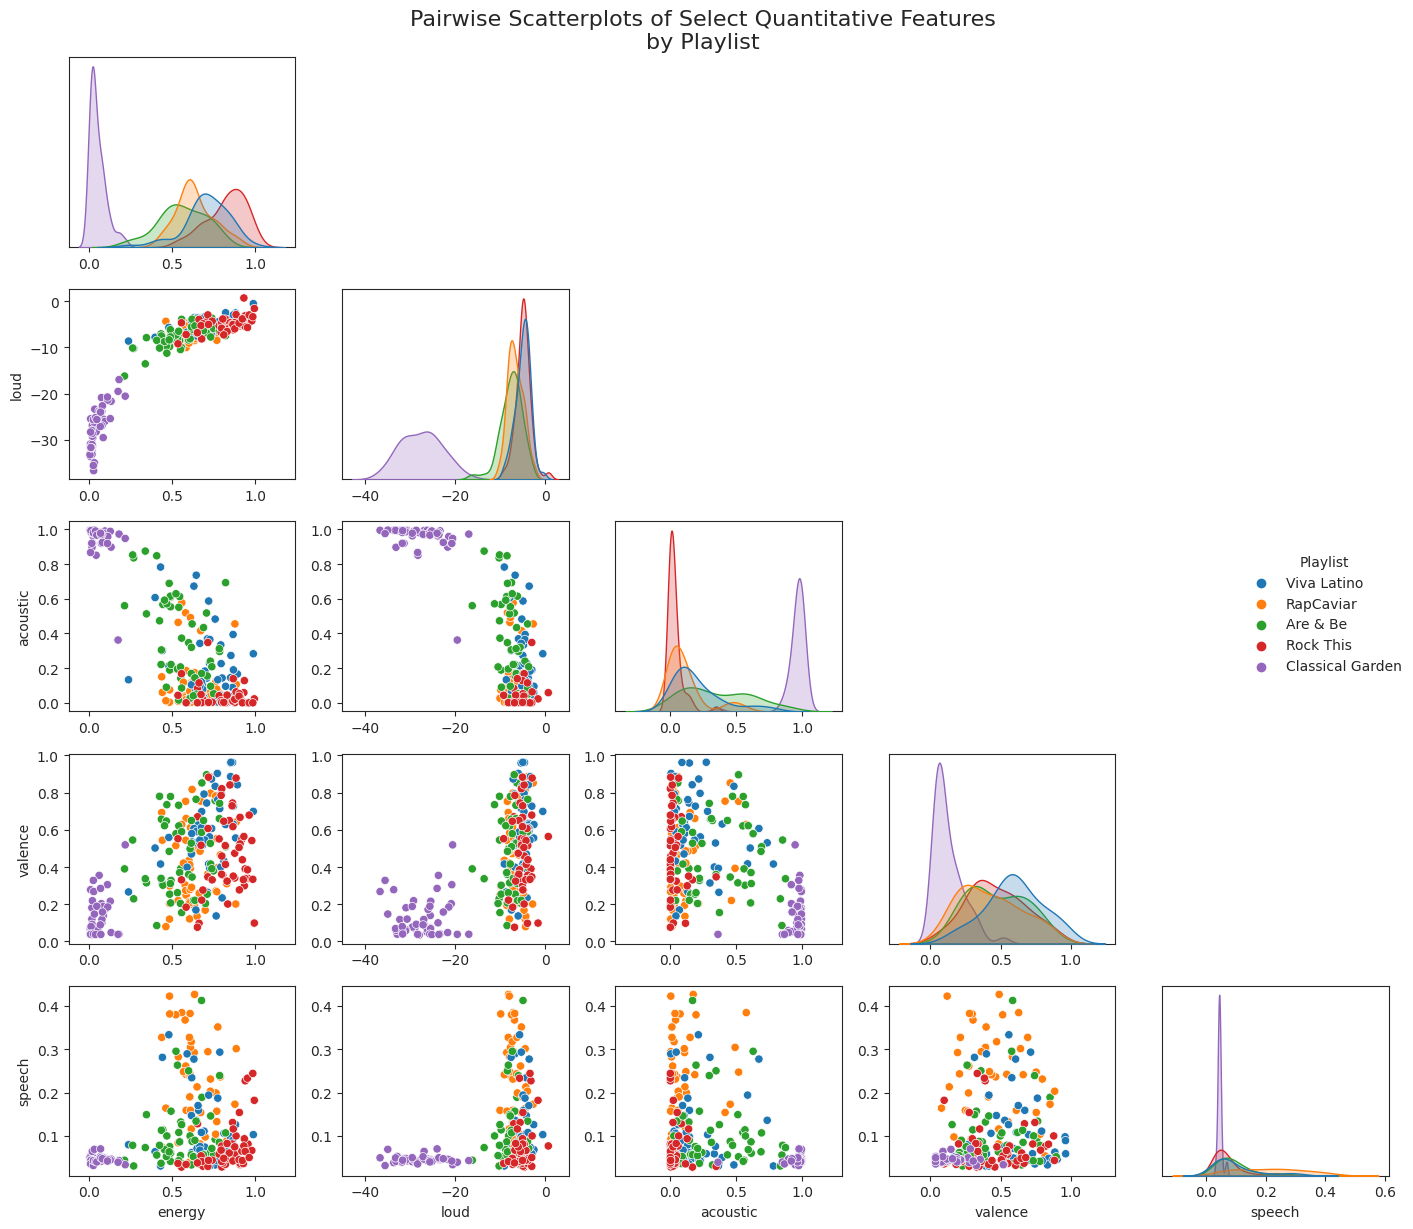

In [ ]:
plot = sns.pairplot(data=track_df,
                    vars=features,
                    hue='playlist',
                    kind='scatter',
                    diag_kind='kde',
                    corner=True,
                    );

sns.despine(top=False, right=False)

plot.fig.suptitle(t="Pairwise Scatterplots of Select Quantitative Features\nby Playlist", fontsize=16);

for ax in plot.axes.flatten():
  if ax:
    ax.tick_params(axis='both', labelleft=True, labelbottom=True)

plot._legend.set_title("Playlist");
sns.move_legend(plot, "right")

plt.tight_layout()
plt.show()

Ridgeplot of a given quantitative feature by decade:

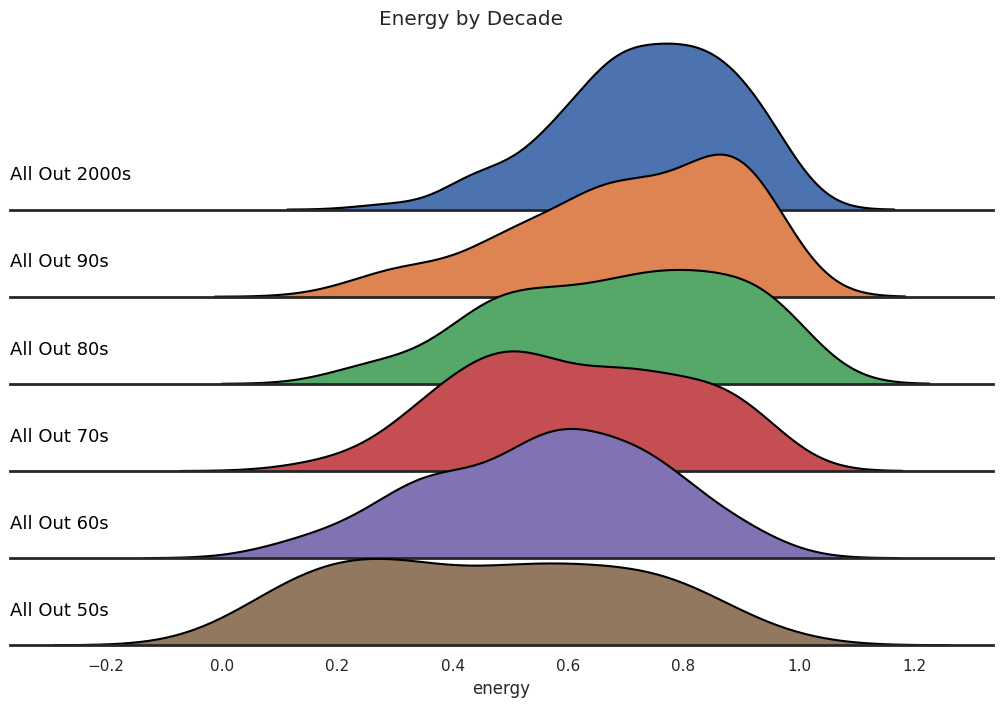

In [ ]:
feature = 'energy'
feature_label = feature_specs[feature]['label']

track_df['playlist'] = get_playlists(track_df, decade)
track_df['playlist'] = pd.Categorical(track_df['playlist'],
                                   categories=decade,
                                   ordered=True)

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})

g = sns.FacetGrid(track_df, row="playlist", hue="playlist", aspect=9, height=1.2)
g.map_dataframe(sns.kdeplot, x=feature, fill=True, alpha=1)
g.map_dataframe(sns.kdeplot, x=feature, color='black')
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "playlist")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], xlabel=feature, ylabel=None)
g.despine( left=True)
plt.suptitle(f"{feature_label} by Decade", y=0.98);

In [ ]:
my_playlists = [
    "RapCaviar",
    "Rock This",
    "Classical Garden",
    "Music for Plants",
    "Melantronic"
]

track_df['playlist'] = get_playlists(track_df, my_playlists)

in_playlist = [playlist in my_playlists for playlist in track_df['playlist'].tolist()]

<ipython-input-97-516815c84bfc>:81: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plot = ax.scatter(x=x, y=y, c=color, cmap=cm, vmin=vmin, vmax=vmax, alpha=0.5, s=size);


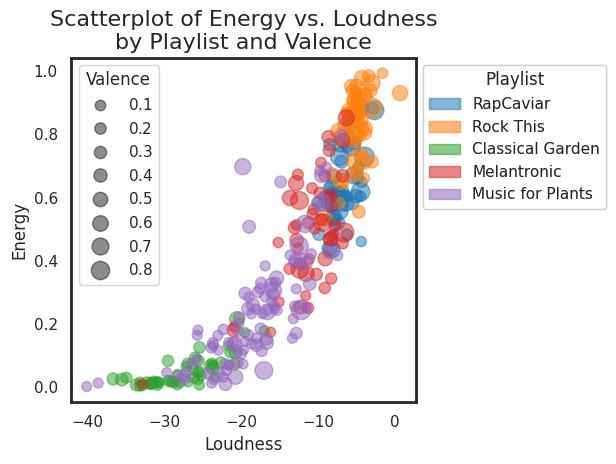

In [ ]:
xvar = 'loud'
yvar = 'energy'

by_color = "playlist"
by_size = "valence"


if "playlist" in [by_color, by_size]:
  df = track_df[in_playlist]
else:
  df = track_df


x = df[xvar]
y = df[yvar]


if by_color in quant_features:

  color = df[by_color]
  cm = plt.colormaps.get_cmap('viridis')

  vmax = df[by_color].max()
  vmin = df[by_color].min()

elif by_color in cat_features + ['playlist']:

  num_labels = len(df[by_color].unique().tolist())
  if num_labels <= 10:
    cm = plt.colormaps.get_cmap('tab10')
  else:
    cm = plt.colormaps.get_cmap('tab20')

  if by_color == 'playlist':
    levels, labels = pd.factorize(df[by_color])

  else:
    levels = df[by_color].cat.codes
    labels = feature_specs[by_color]['values']

  color = [cm(i) for i in levels]
  color_handles = [patches.Patch(color=cm(i), label=c, alpha=0.5) for i, c in enumerate(labels)]

  vmin, vmax = None, None

else:
  print("Invalid datatype for by_color variable.")


if by_size in quant_features:

  max = df[by_size].max()
  min = df[by_size].min()

  mean = df[by_size].mean()
  std = df[by_size].std()

  scaled = (df[by_size] - min) / (max - min)
  size = 50 * 4 ** scaled

  def inv_size(s):
    return (np.log(s / 50) / np.log(4)) * (max - min) + min

else:
  print("Invalid datatype for by_size variable.")


fig, ax = plt.subplots()

tf = [
    feature_specs[yvar]['label'],
    feature_specs[xvar]['label'],
    feature_specs[by_color]['label'],
    feature_specs[by_size]['label']
]
plt.title(label=f"Scatterplot of {tf[0]} vs. {tf[1]}\nby {tf[2]} and {tf[3]}", fontsize=16);

plt.xlabel(feature_specs[xvar]['label'])
plt.ylabel(feature_specs[yvar]['label'])

plot = ax.scatter(x=x, y=y, c=color, cmap=cm, vmin=vmin, vmax=vmax, alpha=0.5, s=size);
force_aspect(ax)

handles, labels = plot.legend_elements(prop="sizes", alpha=0.5, func=inv_size)
size_legend = ax.legend(handles, labels, loc="best", title=feature_specs[by_size]['label'], facecolor='white')
ax.add_artist(size_legend)

if by_color in quant_features:
  ticks = [vmax * t + vmin * (1 - t) for t in np.linspace(vmin, vmax, 5)]
  plt.colorbar(plot, label=feature_specs[by_color]['label'], ticks=ticks)

elif by_color in cat_features + ['playlist']:
  color_legend = ax.legend(handles=color_handles, title=feature_specs[by_color]['label'], bbox_to_anchor=([1, 1]), loc='upper left', facecolor='white')
  ax.add_artist(color_legend)

plt.tight_layout()
plt.show()

In [ ]:
# rand_track = random.choice(track_df[in_playlist].index.tolist())

# x_coord = track_df.loc[rand_track, xvar]
# y_coord = track_df.loc[rand_track, yvar]

# name = track_df.loc[rand_track, 'name']

# track_artists = track_df.loc[rand_track, 'artists']
# num_artists = len(track_artists)

# artists = ""
# for i, artist in enumerate(track_artists):
#   if 0 < i == num_artists - 1:
#     artist = " ".join(["and", artist])
#   if num_artists < 3:
#     artists = " ".join([artists, artist])
#   else:
#     artists = ", ".join([artists, artist])
# artists = artists.strip(", ")

# label = f"{name}\n{artists}"

# plt.text(x=x_coord, y=y_coord, s=label)

## Testing stuff

In [ ]:
df = pd.DataFrame(
    data={
        "playlist": all_playlists,
        "explicit": explicit,
        "not_explicit": not_explicit
        }
)

df['explicit_p'] = df['explicit'] / (df['not_explicit'] + df[ex])
df.head()

,playlist,explicit,not_explicit,explicit_p
0,All Out 2000s,25,75,0.333
1,All Out 50s,12,88,0.136
2,All Out 60s,3,97,0.031
3,All Out 70s,1,99,0.010
4,All Out 80s,0,100,0.000


## Further analysis

In [ ]:
# audio_analysis_keys = [
  #     'track_id',
  #     'analysis_time',
  #     'offset',
  #     'fade_in',
  #     'fade_out',
  #     'sum_samples',
  #     'sample_window',
  #     'sample_rate',
  #     'channels',
  #     'beats',
  #     'beats_cont',
  #     'tatums',
  #     'tatums_conf',
  #     'sections',
  #     'sections_conf',
  #     'segments',
  #     'segments_conf',
  #     'section_loud',
  #     'section_tempo',
  #     'section_tempo_conf',
  #     'section_key',
  #     'section_key_conf',
  #     'section_mode',
  #     'section_mode_conf',
  #     'section_time_sig',
  #     'section_time_sig_conf'
  #     'segment_loud',
  #     'segment_pitch',
  #     'segment_timber',
  # ]
  # audio_analysis_dict = {key: [] for key in audio_analysis_keys}